In [161]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
from datasets.seq_mnist import SequentialMNIST_double
from datasets import seq_mnist as sm

import models.seqae as seqae
import models.base_networks as bn 
import models
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
from einops import rearrange
from utils import notebook_utils as nb
from utils import evaluations as ev



import copy

import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

    
from utils import yaml_utils as yu
import yaml
rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'
jobdir = '/mnt/vol21/masomatics/ULASclone/jobs'

mode = 'so3'
dat_root = f"""/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/{mode}"""

playground_path = os.path.join(result_dir, '20220913_playground_model')

#targpath = playground_path

targpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221104_mnist_double_0/same_objectFalse_dim_m128'



In [162]:

targlist = os.listdir(targpath)

targlist = nb.model_exists(targlist,  targpath)
print(targlist)

[]


In [163]:
reload(ev)
results = {} 
inferred_Ms = {} 
model_configs = {}
models = {}
tp = 15
n_cond = 2
device =0
predictive = False
reconstructive = False
repeats=3


#targdir_pathlist = [os.path.join(targpath, targdir) for targdir in targlist] 

targdir_pathlist = []
targdir_pathlist.append(targpath)

print(targdir_pathlist)

reload(ev)
reload(bn)
allresults, targ, xnext = ev.prediction_evaluation(targdir_pathlist, device=0,
                                                                        n_cond=2,
                                                                        tp=tp,
                                                                    repeats=1,
                           predictive= False , reconstructive = False)

results = allresults['results']





['/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221104_mnist_double_0/same_objectFalse_dim_m128']
{'args': {'T': 17, 'backgrnd': False, 'max_T': 17, 'max_angle_velocity_ratio': [-0.5, 0.5], 'max_color_velocity_ratio': [-0.5, 0.5], 'only_use_digit4': True, 'pair_transition': True, 'root': '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/MNIST', 'same_object': False, 'train': True}, 'fn': './datasets/seq_mnist.py', 'name': 'SequentialMNIST_double'}
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221104_mnist_double_0/same_objectFalse_dim_m128 
 snapshot_model_iter_50000


100%|██████████| 183/183 [00:23<00:00,  7.80it/s]

tensor([0.9614, 1.1129, 1.5605, 1.9805, 2.2285, 2.5043, 3.0012, 3.5112, 3.9131,
        4.3305, 4.8255, 5.3419, 5.7524, 6.1819, 6.6653])


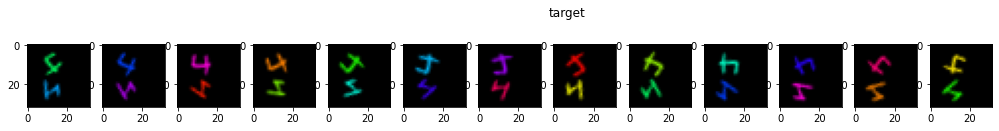

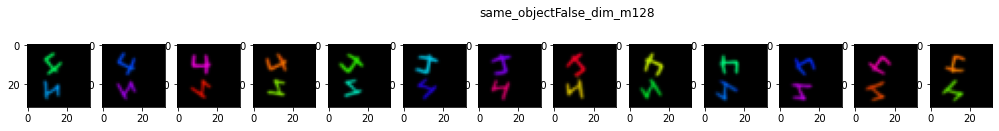

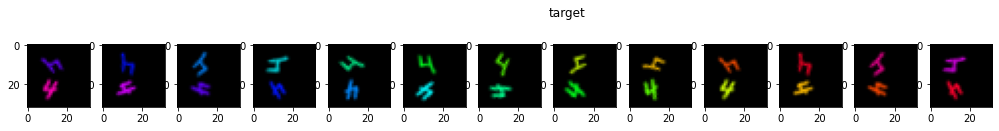

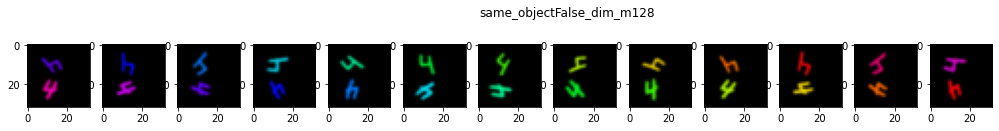

In [164]:
mode = targpath


idx = 10
device = 0
reload(sm)
for idx in list(range(8, 10)):
    figsize = (20,2)


    plt.figure(figsize = figsize)
    for k in range(tp-n_cond):
        tn = torch.permute(targ[idx][k+n_cond], (1,2,0))
        plt.subplot(1, tp, k+1)
        plt.imshow(tn, interpolation=None)
    plt.suptitle("target")  

#     for mode in list(allresults['models'].keys()):
    plt.figure(figsize = figsize)
    xnext, M = ev.predict(targ, allresults['models'][mode].to(device),
                n_cond=2, tp=tp, device=device, swap =False,
                predictive=False, reconstructive=False)
    xnext = xnext.to('cpu')
    M = M.to('cpu')
    for k in range(tp-n_cond):
        xn = torch.permute(xnext[idx][k], (1,2,0))
        plt.subplot(1, tp, k+1)
        plt.imshow(xn, interpolation=None)
    plt.suptitle(mode.split('/')[-1])    




In [165]:
targ.shape

torch.Size([18, 15, 3, 32, 32])

In [166]:
model = allresults['models'][mode].to('cpu')
encoded = model.encode(targ)

In [167]:
from utils import optimize_bd_cob as obc
from utils import optimize_lasso as ol



ep:9 loss:7.072764492165508
ep:19 loss:7.057627492471739
ep:29 loss:7.049518309485133
ep:39 loss:7.045038648518501
ep:49 loss:7.0417013884978275
ep:59 loss:7.040151571092929
ep:69 loss:7.037085732300369
ep:79 loss:7.035904878788066
ep:89 loss:7.034139908572167
ep:99 loss:7.033132861795918


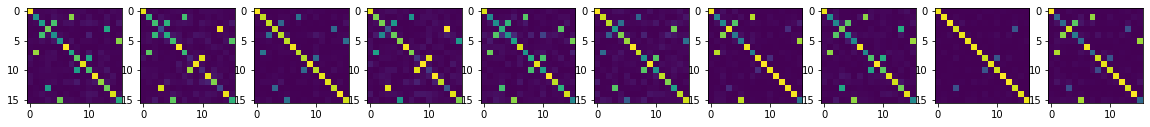

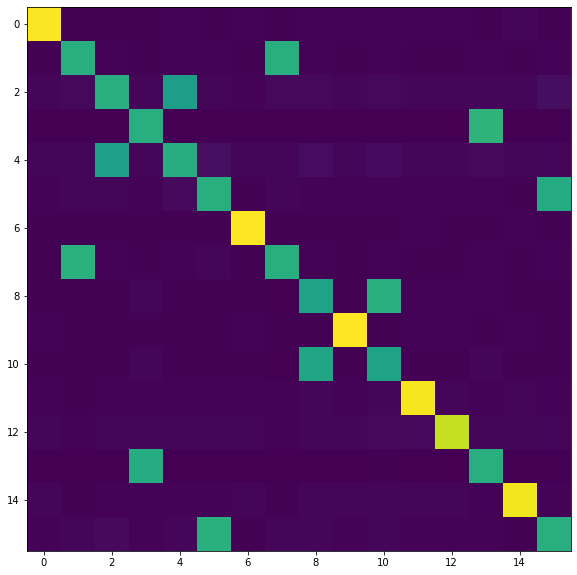

In [168]:
from utils import optimize_bd_cob as obc 
reload(obc)
Ms = allresults['Ms'][targpath]
normalize=False
ChangeB= obc.optimize_bd_cob(Ms,  lr=0.1, epochs_monitor=10, n_epochs=100, normalize=True) 

PMPs = ChangeB(Ms)

plt.figure(figsize=(20, 20))
for k in range(10):
    plt.subplot(1, 10, k+1)
    plt.imshow(torch.abs(PMPs[k]).detach().to('cpu'))
    
plt.figure(figsize=(10, 10))
plt.imshow(torch.mean(torch.abs(PMPs.detach()), axis=0))




In [169]:
reload(obc)
absM = torch.mean(torch.abs(PMPs.detach()), axis=0)

partitions = obc.obtain_blocks_old(absM)
print(partitions)

[[0], [1, 7], [2, 4], [3, 13], [5, 15], [6], [8, 10], [9], [11], [12], [14]]


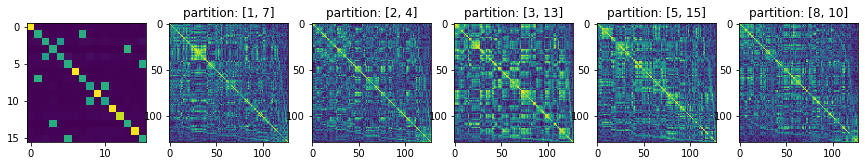

In [175]:
reload(obc)
reload(ol)
checkidx = 0
U = encoded[checkidx] 

plt.figure(figsize=(20,20))
pltidx = 1

plt.subplot(1, 8, pltidx)
plt.imshow(absM)
for k in range(len(partitions)):
    checkfreq = partitions[k]
    if len(checkfreq) > 1: 

        freqU = U[:, :, checkfreq]
        freqU = freqU / torch.sqrt(torch.sum(freqU**2 , axis=-1, keepdims=True))

        freqU_innerP = torch.abs(ol.innerprod(freqU).detach())
        plt.subplot(1, 8, pltidx+1)
        #plt.imshow(freqU_innerP)
        plt.imshow(obc.blockify(freqU_innerP, thresh=1.0, hard=True))
        pltidx = pltidx + 1
        plt.title(f"""partition: {checkfreq}""")
        #plt.imshow(freqU_innerP)


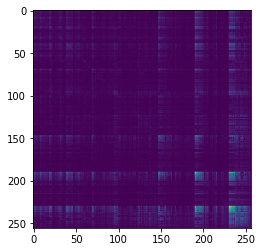

In [143]:
reload(obc)

plt.imshow(obc.blockify(freqU_inner, thresh=1.0, hard=True))

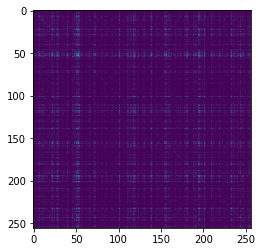

In [144]:
plt.imshow(obc.blockify(freqU_innerP, thresh=1.0, hard=False))

In [145]:
checkfreq 

[3, 13]

In [121]:


# def edge_chaser(adj):
#     edges = [ [np.where(adj > 0)[0][k],  np.where(adj > 0)[1][k]] for k in range(len(adj))]
#     clusters = [] 
#     for edge in edges:
#         startpt = edge[0]
#         nextpt = edge[1]
#         cluster = []
#         while nextpt != startpt:
#             next_edge = 
            
            
# def next_edge(edges, vertex)


Text(0.5, 1.0, 'partition:ALL')

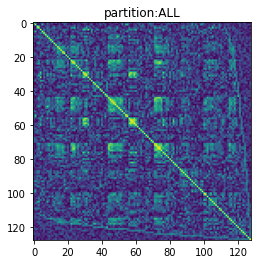

In [179]:
allU = U[:, :, :]
allU = allU / torch.sqrt(torch.sum(allU**2 , axis=-1, keepdims=True))

allU_innerP = torch.abs(ol.innerprod(allU).detach())
#plt.imshow(freqU_innerP)
plt.imshow(obc.blockify(allU_innerP, thresh=1.0, hard=True))
pltidx = pltidx + 1
plt.title(f"""partition:ALL""")
#plt.imshow(freqU_innerP)

